<a href="https://colab.research.google.com/github/chrisway613/diffusion-models-class/blob/cw/unit4/ControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Aug 14 05:11:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.5 MB/s eta 0:00:00


In [ ]:
!pip install -q opencv-contrib-python

In [ ]:
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.9/261.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00


# Canny

## Load Image

In [ ]:
from diffusers.utils import load_image


image_url = "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png" # @param
image = load_image(image_url)

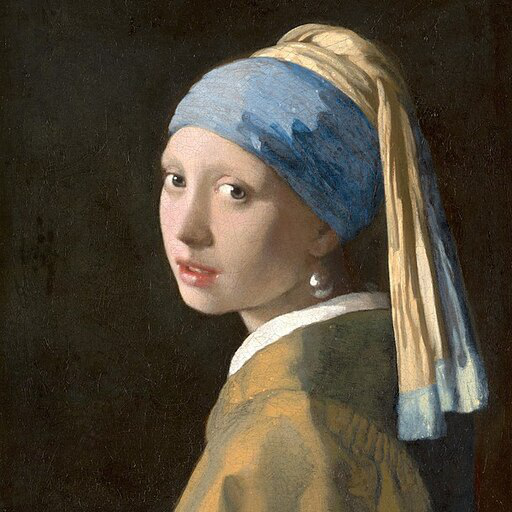

In [ ]:
image

In [ ]:
image.size

(512, 512)

In [ ]:
image.mode

'RGB'

## Canny Detection

canny image type: <class 'numpy.ndarray'>
canny image shape: (512, 512)


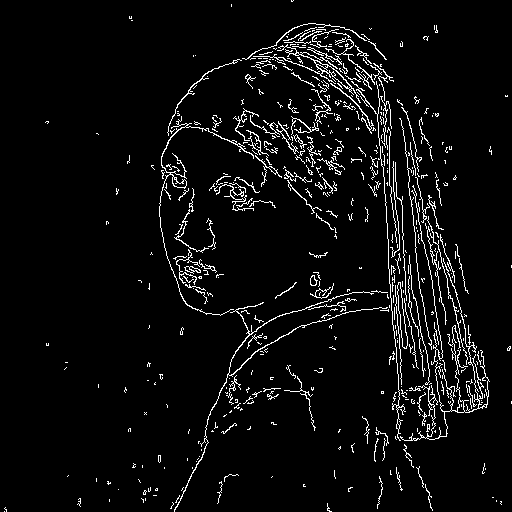

In [ ]:
import cv2
import numpy as np

from PIL import Image


canny_threshold_low = 100  # @param
canny_threshold_high = 200  # @param

canny_image = cv2.Canny(np.array(image), canny_threshold_low, canny_threshold_high)
print(f"canny image type: {type(canny_image)}")
print(f"canny image shape: {canny_image.shape}")

canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image] * 3, axis=-1)
canny_image = Image.fromarray(canny_image)
canny_image

## Build ControlNet & Pipeline

In [ ]:
import torch

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel


controlnet_id = "lllyasviel/sd-controlnet-canny"  # @param
controlnet = ControlNetModel.from_pretrained(controlnet_id, torch_dtype=torch.float16)

In [ ]:
controlnet

ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_out): Conv2d(256, 320, ker

In [ ]:
pipe_id = "runwayml/stable-diffusion-v1-5"  # @param
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    pipe_id,
    controlnet=controlnet,
    torch_dtype=torch.float16
)
pipe

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.14.0",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Set Scheduler

In [ ]:
from diffusers import UniPCMultistepScheduler


pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler

UniPCMultistepScheduler {
  "_class_name": "UniPCMultistepScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "disable_corrector": [],
  "dynamic_thresholding_ratio": 0.995,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "predict_x0": true,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_p": null,
  "solver_type": "bh2",
  "steps_offset": 1,
  "thresholding": false,
  "trained_betas": null
}

## Sampling

In [ ]:
from typing import List


def image_grid(imgs, rows: int, cols: int):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB",(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, (i % cols * w, i // cols * h))

    return grid

🔔 *We must put model & pipe on GPU, cuz we implemented them in HALF precision.*

In [ ]:
controlnet.to("cuda")
pipe.to("cuda")

StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.14.0",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
prompt = ", best quality, extremely detailed"  # @param
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"  # @param

name1 = "Mona Lisa"  # @param
name2 = "Taylor Swift"  # @param
name3 = "Rihanna"  # @param
name4 = "Billie Eilish"  # @param

prompts = [name + prompt for name in [name1, name2, name3, name4]]

seed = 2  # @param
generator = [torch.Generator(device="cpu").manual_seed(seed) for _ in range(len(prompts))]

num_inf_steps = 50  # @param

samples = pipe(
    prompts,
    canny_image,
    negative_prompt=[negative_prompt] * len(prompts),
    generator=generator,
    num_inference_steps=num_inf_steps
)
print(type(samples))

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.pipelines.stable_diffusion.StableDiffusionPipelineOutput'>


In [ ]:
print(type(samples.images))
print(type(samples.images[0]))

<class 'list'>
<class 'PIL.Image.Image'>


In [ ]:
len(samples.images)

4

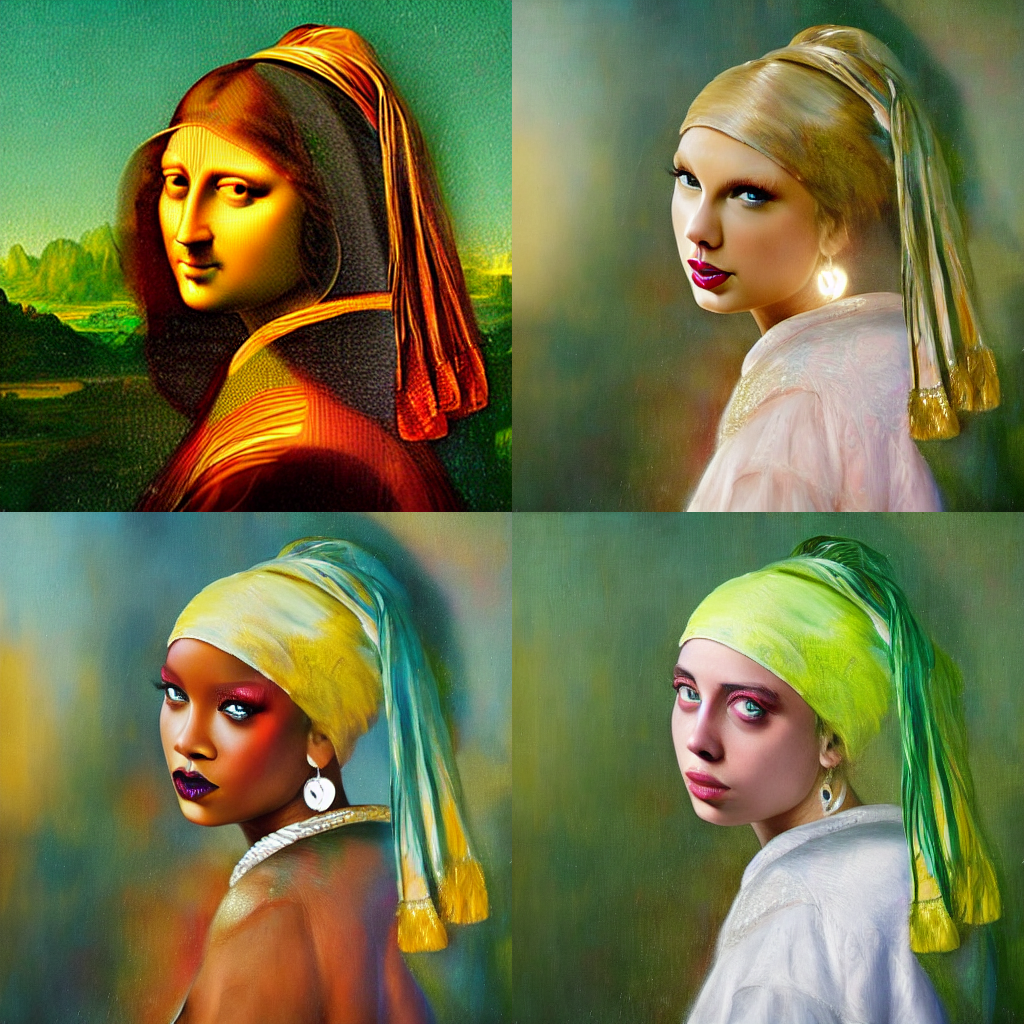

In [ ]:
image_grid(samples.images, 2, 2)

# Open Pose

## Load images

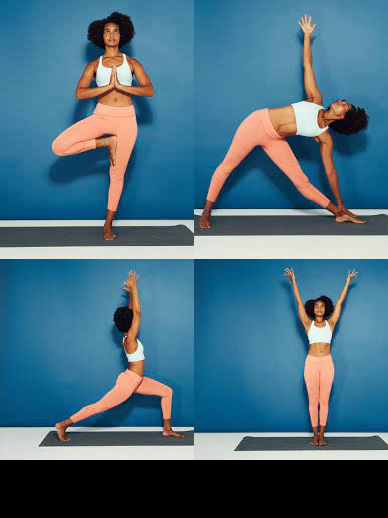

In [ ]:
url1 = "yoga1.jpeg"  # @param
url2 = "yoga2.jpeg"  # @param
url3 = "yoga3.jpeg"  # @param
url4 = "yoga4.jpeg"  # @param

imgs = [
    load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url)
    for url in [url1, url2, url3, url4]
]
image_grid(imgs, 2, 2)

## Pose Detection

In [ ]:
from controlnet_aux import OpenposeDetector


model_id = "lllyasviel/ControlNet"  # @param
model = OpenposeDetector.from_pretrained(model_id)
model

In [ ]:
poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

## Build ControlNet & Pipeline

In [ ]:
controlnet_id = "fusing/stable-diffusion-v1-5-controlnet-openpose"  # @param
controlnet = ControlNetModel.from_pretrained(controlnet_id, torch_dtype=torch.float16)
controlnet

ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_out): Conv2d(256, 320, ker

In [ ]:
pipe_id = "runwayml/stable-diffusion-v1-5"  # @param
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    pipe_id,
    controlnet=controlnet,
    torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.14.0",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

## Sampling

In [94]:
seed = 2 # @param {type:"integer"}
generator = [torch.Generator(device="cpu").manual_seed(seed) for _ in range(len(poses))]

prompt = "super-hero character in DC comic, best quality, extremely detailed" # @param {type:"string"}
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality" # @param {type:"string"}

num_inf_steps = 35 # @param {type:"integer"}

outputs = pipe(
    [prompt] * len(poses),
    poses,
    negative_prompt=[negative_prompt] * len(poses),
    generator=generator,
    num_inference_steps=num_inf_steps
)

  0%|          | 0/35 [00:00<?, ?it/s]

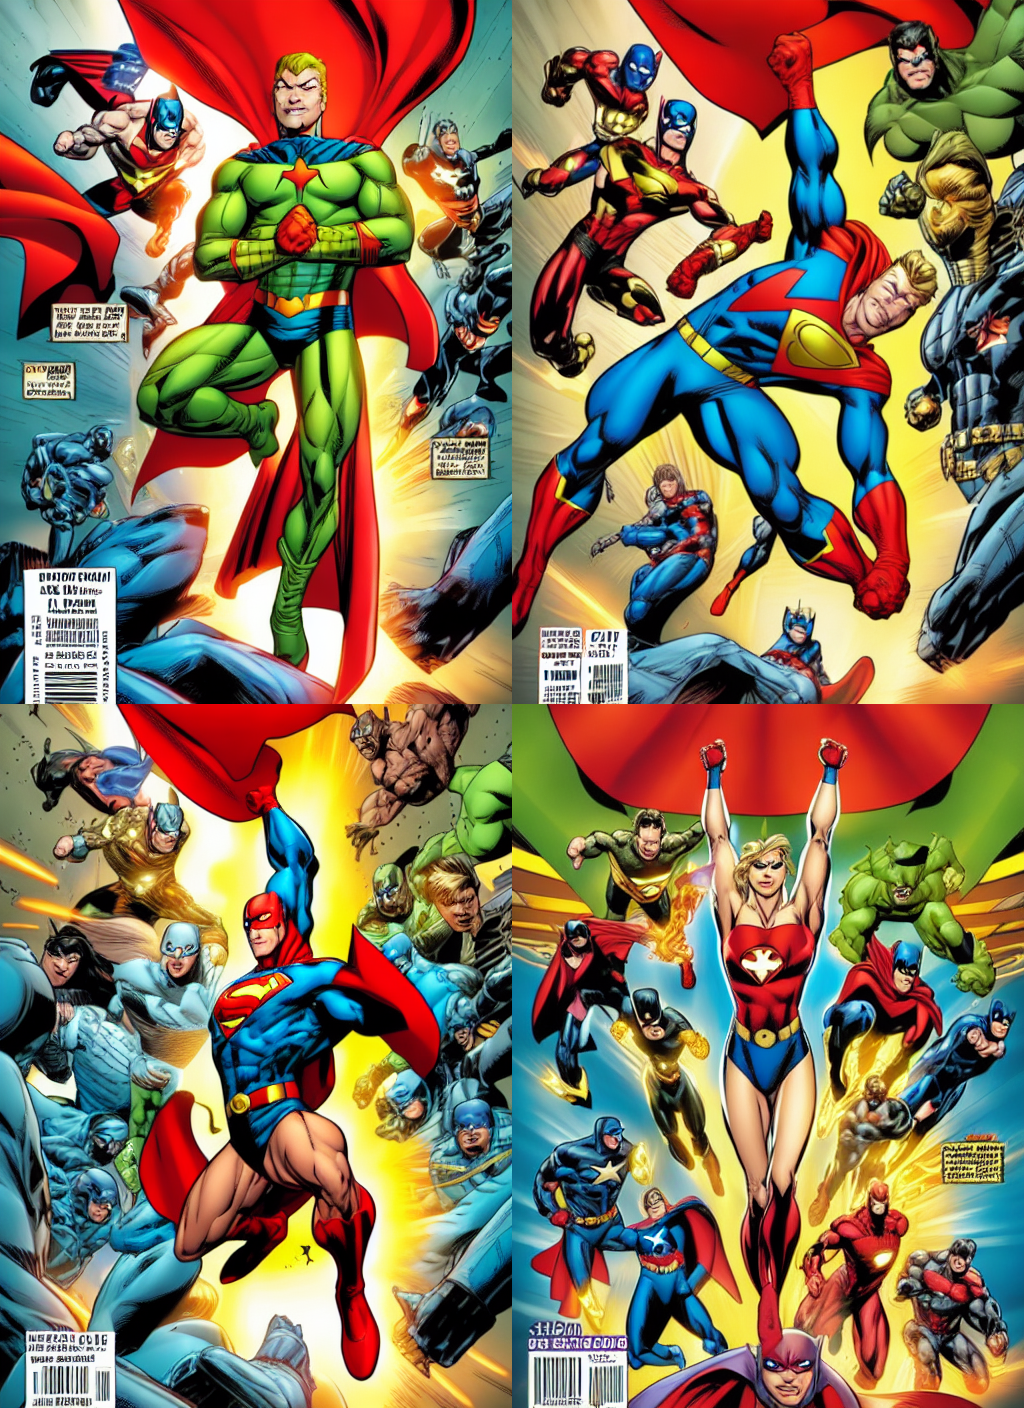

In [95]:
image_grid(outputs.images, 2, 2)